<a href="https://colab.research.google.com/github/capozzolicaluan/MSWEPtest/blob/main/spatial_analyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Limpar todas as variáveis
from IPython import get_ipython
get_ipython().magic('reset -sf')


In [2]:
# Importando as bibliotecas necessárias
import requests
import pandas as pd
import gc
from google.colab import data_table
import math
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


# Liberar memória manualmente
_ = gc.collect()

In [3]:
def uneDataframes(df1, df2):

  df_completo = pd.concat([df1, df2], axis=1)

  if df_completo.shape[1] == 4:
    df_completo.columns = ['Estacao', 'Latitude', 'Longitude', 'Anual']
  elif df_completo.shape[1] == 15:
    df_completo.columns = ['Estacao','Latitude', 'Longitude','Jan','Feb','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
  else:
    print("Número de colunas não suportado")
    return

  return df_completo

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
from posixpath import join
file_path = "/content/drive/MyDrive/Colab/txts"

In [6]:
estacoes_lat_lon = pd.read_csv(join(file_path, "estacoes_lat_lon.txt"), sep = ';', header=None)

# Assigning column names to estacoes_lat_lon for clarity
estacoes_lat_lon.columns = ['Estacao', 'Latitude', 'Longitude']

In [7]:
lista_arquivos = os.listdir(join(file_path,"error_result"))

In [8]:
erros_dicionario = {}

for arquivo in lista_arquivos:
  erro_df = pd.read_csv(join(file_path,"error_result",arquivo), sep = ';')

  erro_df_final = uneDataframes(df1=estacoes_lat_lon, df2=erro_df)

  nome_base = os.path.splitext(arquivo)[0]

  # Adiciona ao dicionário
  erros_dicionario[nome_base] = erro_df_final

In [9]:
# prompt: fazer uma lista com os nomes das chaves dos dicionarios do erros_dicionario
nomes_chaves = list(erros_dicionario.keys())

In [10]:
df = erros_dicionario[nomes_chaves[6]]
df

,Estacao,Latitude,Longitude,Anual
0,58040000,-23.2386,-45.3067,0.314674
1,58204000,-22.8119,-45.1825,0.481092
2,58183000,-22.9117,-45.4700,0.514573
3,58380001,-22.1628,-43.2864,0.550797
4,58405000,-22.3319,-43.1317,NaN
5,58520000,-21.9667,-43.3744,0.498056
6,58530000,-22.2708,-44.3900,0.438216
7,58550001,-22.0861,-43.8200,0.349539
8,58585000,-22.0844,-43.5589,0.542127
9,58680001,-21.6658,-42.0811,0.470221


In [11]:
# Shapefile de polígono (por exemplo, bacias)
gdf_bacia = gpd.read_file("/content/drive/MyDrive/Colab/GIS/hidrografia_pdosul/bacia_shape.shp")

# Shapefile de linhas (por exemplo, conexões entre pontos)
gdf_hidrografia = gpd.read_file("/content/drive/MyDrive/Colab/GIS/hidrografia_pdosul/hidrografia.shp")

In [12]:
# Criar GeoDataFrame com geometria de pontos
gdf_pontos = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
    crs="EPSG:4326")

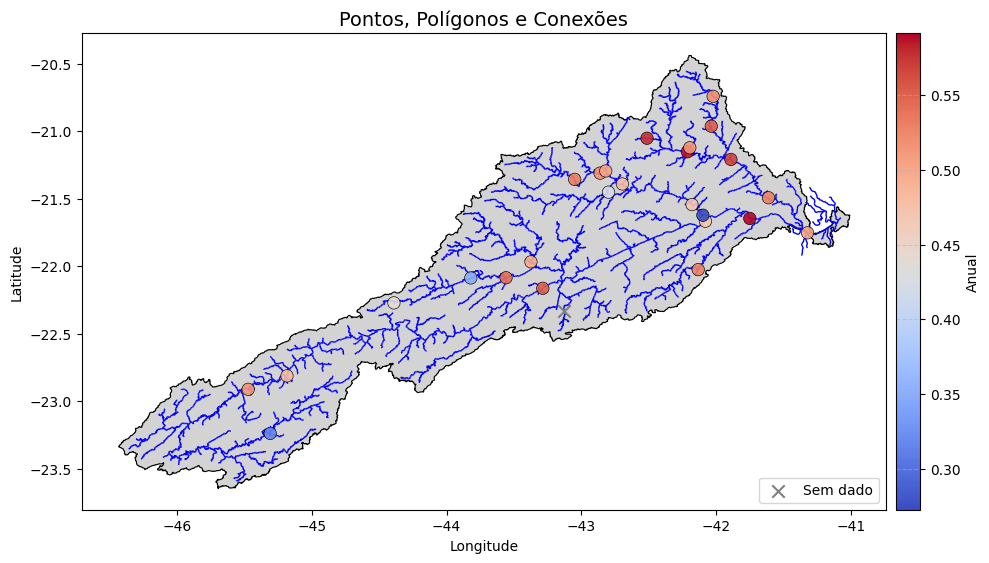

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))

# 1. Polígono de fundo
gdf_bacia.plot(ax=ax, facecolor='lightgrey', edgecolor='black', linewidth=0.8, zorder=1)

# 2. Linhas (hidrografia)
gdf_hidrografia.plot(ax=ax, color='blue', linewidth=1, zorder=2)

# 3. Cria divisor para barra de legenda proporcional ao eixo
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)  # ajusta o tamanho e a distância da barra

# 4. Plot dos pontos com valor, armazenando o retorno
pontos_com_valor = gdf_pontos.dropna(subset=['Anual'])
plot = pontos_com_valor.plot(
    ax=ax,
    column='Anual',
    cmap='coolwarm',
    markersize=80,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.9,
    zorder=4,
    legend=False  # Desliga a legenda automática
)

# 5. Adiciona colorbar manualmente
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=pontos_com_valor['Anual'].min(),
                                                               vmax=pontos_com_valor['Anual'].max()))
sm._A = []  # necessário para o ScalarMappable funcionar corretamente
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Anual')

# 6. Pontos com NaN
gdf_pontos[gdf_pontos['Anual'].isna()].plot(
    ax=ax,
    color='grey',
    marker='x',
    markersize=80,
    label='Sem dado',
    zorder=3
)

# Finalização
ax.set_title("Pontos, Polígonos e Conexões", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc='lower right')
ax.set_aspect('equal')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
df = erros_dicionario[nomes_chaves[0]]

In [15]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf_pontos = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

/tmp/ipython-input-25-1639504829.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


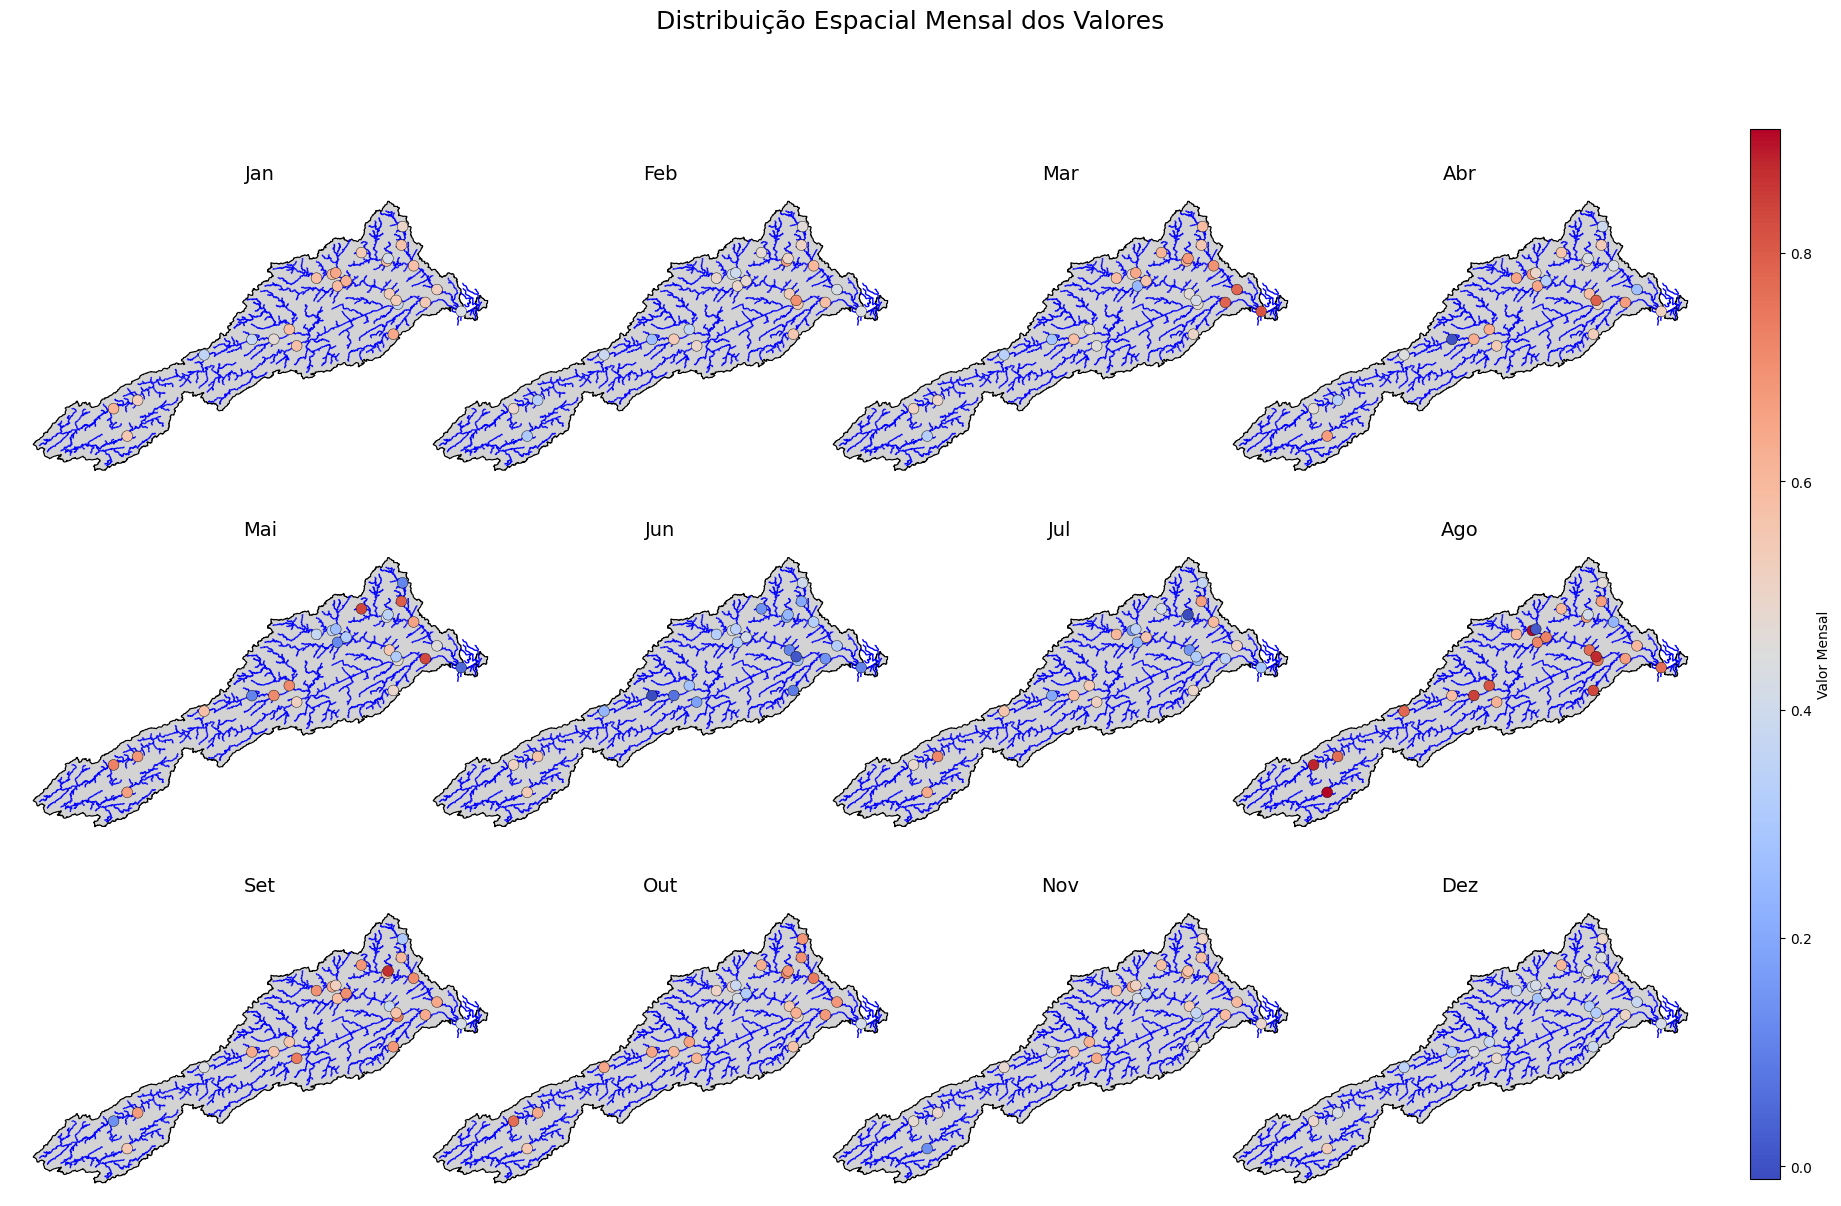

In [25]:
import matplotlib.colors as colors
import matplotlib.cm as cm

# ==== 3. Lista de meses ====
meses = ['Jan', 'Feb', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# ==== 4. Normalização e colormap ====
vmin = gdf_pontos[meses].min().min()
vmax = gdf_pontos[meses].max().max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('coolwarm')

# ==== 5. Criação da figura ====
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# ==== 6. Plot de cada mês ====
for i, mes in enumerate(meses):
    ax = axes[i]

    # Divide em pontos com e sem dado
    gdf_validos = gdf_pontos.dropna(subset=[mes])
    gdf_nulos = gdf_pontos[gdf_pontos[mes].isna()]

    gdf_bacia.plot(ax=ax, facecolor='lightgrey', edgecolor='black', linewidth=0.8, zorder=1)

    gdf_hidrografia.plot(ax=ax, color='blue', linewidth=1, zorder=2)

    # Pontos válidos
    gdf_validos.plot(
        ax=ax,
        column=mes,
        cmap=cmap,
        norm=norm,
        markersize=60,
        edgecolor='black',
        linewidth=0.3,
        zorder=3
    )


    ax.set_title(mes, fontsize=14)
    ax.set_aspect('equal')
    ax.set_axis_off()

# ==== 7. Adiciona barra de cores única ====
cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
fig.colorbar(sm, cax=cax, label='Valor Mensal')

# ==== 8. Título e layout ====
# Ajuste fino dos espaços entre os subplots
fig.subplots_adjust(
    left=0.05, right=0.9, top=0.95, bottom=0.0,  # margens externas
    wspace=-0.2, hspace=-0.5                         # espaço entre colunas e linhas
)

# Título mais próximo da figura
plt.suptitle("Distribuição Espacial Mensal dos Valores", fontsize=18, y=0.93)

plt.show()

/tmp/ipython-input-28-3200547820.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


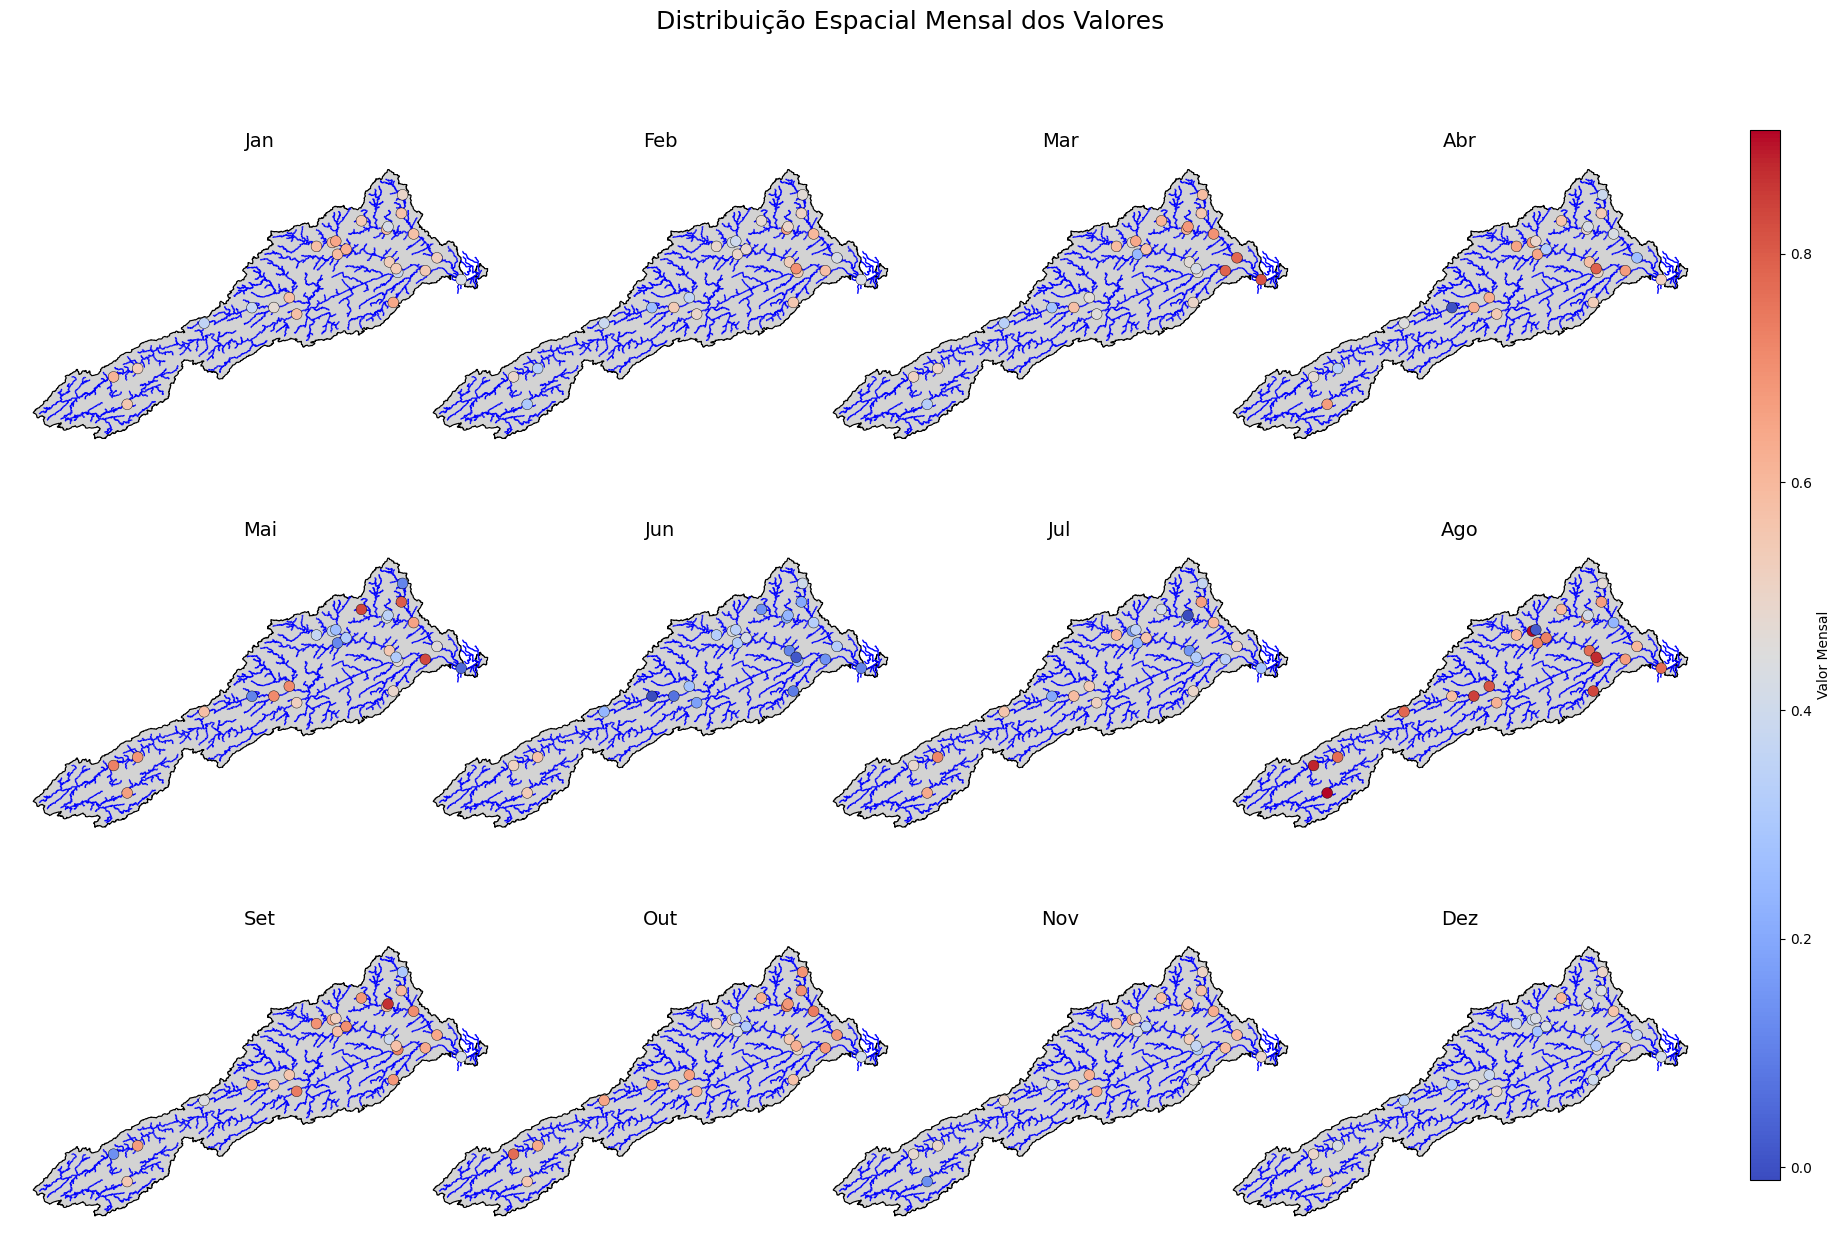

In [28]:
import matplotlib.colors as colors
import matplotlib.cm as cm

# ==== 3. Lista de meses ====
meses = ['Jan', 'Feb', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# ==== 4. Normalização e colormap ====
vmin = gdf_pontos[meses].min().min()
vmax = gdf_pontos[meses].max().max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('coolwarm')

# ==== 5. Criação da figura ====
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# ==== 6. Plot de cada mês ====
for i, mes in enumerate(meses):
    ax = axes[i]

    # Divide em pontos com e sem dado
    gdf_validos = gdf_pontos.dropna(subset=[mes])
    gdf_nulos = gdf_pontos[gdf_pontos[mes].isna()]

    gdf_bacia.plot(ax=ax, facecolor='lightgrey', edgecolor='black', linewidth=0.8, zorder=1)

    gdf_hidrografia.plot(ax=ax, color='blue', linewidth=1, zorder=2)

    # Pontos válidos
    gdf_validos.plot(
        ax=ax,
        column=mes,
        cmap=cmap,
        norm=norm,
        markersize=60,
        edgecolor='black',
        linewidth=0.3,
        zorder=3
    )


    ax.set_title(mes, fontsize=14)
    ax.set_aspect('equal')
    ax.set_axis_off()

# ==== 7. Adiciona barra de cores única ====
cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
fig.colorbar(sm, cax=cax, label='Valor Mensal')

# ==== 8. Título e layout ====
# Ajuste fino dos espaços entre os subplots
fig.subplots_adjust(
    left=0.05, right=0.9, top=0.95, bottom=0.0,  # margens externas
    wspace=-0.2, hspace=-0.4                         # espaço entre colunas e linhas
)

# Título mais próximo da figura
plt.suptitle("Distribuição Espacial Mensal dos Valores", fontsize=18, y=0.93)

plt.show()